In [371]:
print(df_clientes.head())
print(df_tx.head())

                                         id fecha_nacimiento fecha_alta  \
0  9980f12e32711330d5f58460e169e6207afda041       1984-06-19 2015-10-25   
1  93512ea145c3d81ba7a7ff641faf992fd307072e       1986-12-21 2018-02-11   
2  acb2fee5aea2d73a88359d438aaedeea731554f8       1991-02-01 2019-05-12   
3  b627227d2f20116510bcb12de34e6a188cf8d054       1994-05-23 2017-07-19   
4  054be5f40d50b28d2b82af57159343989dd28012       1990-10-03 2017-05-21   

   id_municipio  id_estado                              tipo_persona genero  \
0       6822006         68  Persona Fisica Sin Actividad Empresarial          
1       6822014         68  Persona Fisica Con Actividad Empresarial      F   
2       6115121         61  Persona Fisica Con Actividad Empresarial      M   
3       6923005         69  Persona Fisica Sin Actividad Empresarial      F   
4       6014120         60  Persona Fisica Sin Actividad Empresarial      M   

                               actividad_empresarial  
0                  

Comercios actualizados en la tabla de transacciones.
Número de filas inicial: 346011
Número de filas después de eliminar duplicados: 327591
Número de filas eliminadas: 18420


C:\Users\games\AppData\Roaming\Python\Python310\site-packages\sklearn\calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  if sample_weight is not None:


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       192
           1       0.91      0.90      0.91       384

    accuracy                           0.88       576
   macro avg       0.86      0.86      0.86       576
weighted avg       0.88      0.88      0.88       576

AUC: 0.9178195529513888
Confusion Matrix:
 [[160  32]
 [ 40 344]]


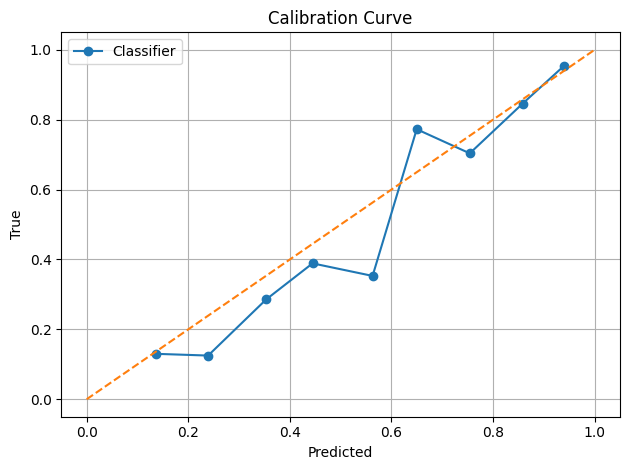

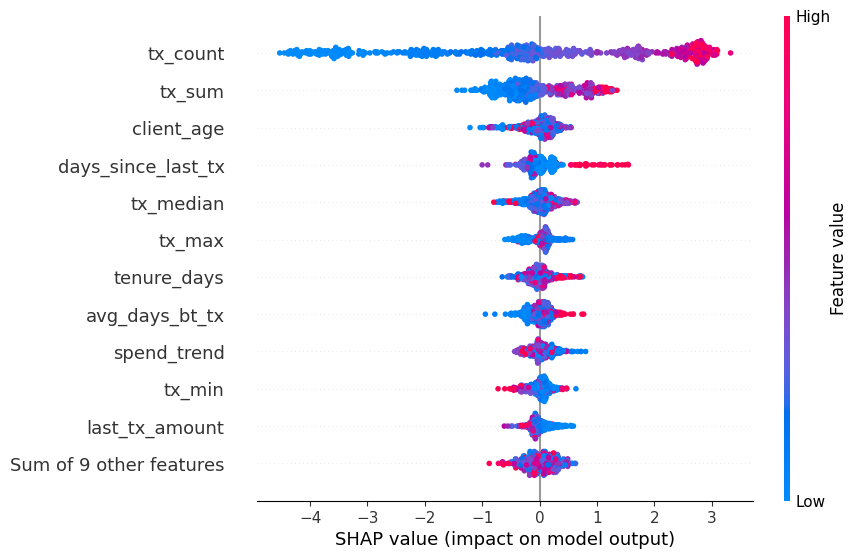


=== Regression on Positives ===
MAE: 251.2409480429464
RMSE: 366.1366735127165
SMAPE: 65.26538095207692


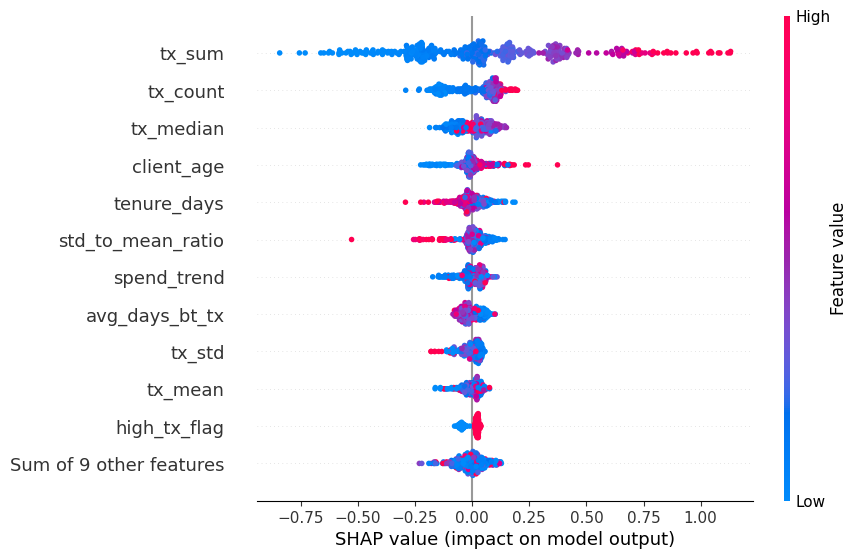


=== Sample Prediction Table ===
      tx_count   tx_sum  tx_mean  tx_std  tx_max  tx_min  tx_median  \
2435        28   734.77    26.24   29.37  132.93    2.40      15.24   
1663        27   975.06    36.11   25.61  104.21    6.34      25.29   
2104        16   882.83    55.18   50.86  175.55    5.82      33.94   
1657        52   776.11    14.93   12.75   52.63    1.79      10.70   
447          6   182.15    30.36   24.69   61.01    4.26      23.22   
640         22   706.78    32.13   29.15  115.12    2.19      23.22   
1673        17  1672.74    98.40  239.06  999.19    4.84      13.57   
2714        50  1133.25    22.66   22.56  101.22    4.72      15.00   
248         65  3294.92    50.69   86.62  553.80    1.43      35.85   
1410        62  1392.92    22.47   33.35  236.03    3.46      17.27   

      days_since_last_tx  tx_freq  client_age  ...  last_tx_amount  \
2435                   1     0.93       30.98  ...           12.07   
1663                  10     0.90       34.02

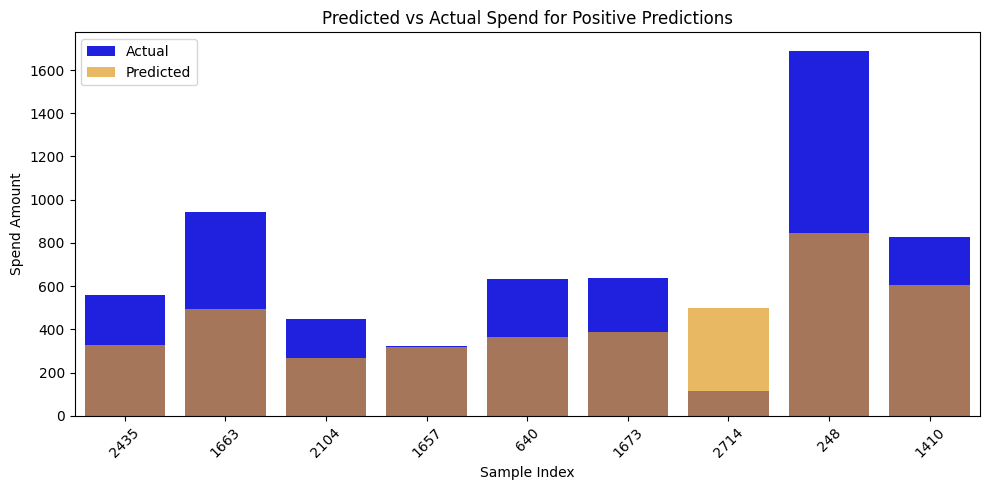

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, mean_absolute_error, mean_squared_error,
                             roc_auc_score, confusion_matrix, precision_recall_curve)
from sklearn.utils import resample
from xgboost import XGBClassifier, XGBRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

WINDOW_SIZE = 30
LABEL_WINDOW = 14
FREQ = '3D'
POS_TO_NEG_RATIO = 2

csv_path1 = 'C:/Users/games/OneDrive/Desktop/heybanco/data/heybanco/base_clientes_final.csv'
csv_path2 = 'C:/Users/games/OneDrive/Desktop/heybanco/data/heybanco/base_transacciones_final.csv'
df_clientes = pd.read_csv(csv_path1, parse_dates=["fecha_nacimiento", "fecha_alta"])
df_tx = pd.read_csv(csv_path2, parse_dates=["fecha"])

# prompt: Junta en comercio los siguientes:
#  20. MERCADO PAGO
# 62. MERCADOPAGO
# 22. WALMART
# 61. WAL-MART
# 6. 7 ELEVEN
# 52. 7ELEVEN
# 67. DIDI FOOD
# 69. DIDIFOOD
# 34. TOTALPLAY
# 45. TOTAL PLAY
# 71. APLAZO
# 72. APLAZ
# 79. SMARTFIT
# 94. SMART FIT
# 42. DIDI RIDES
# 66. DIDI
# Son lo mismo, entonces son duplicados.
# Y el texto que decidas dejar en comercio, lo tienes que actualizar en las transacciones.

duplicates_mapping = {
    'MERCADOPAGO': 'MERCADO PAGO',
    'WAL-MART': 'WALMART',
    '7ELEVEN': '7 ELEVEN',
    'DIDIFOOD': 'DIDI FOOD',
    'TOTAL PLAY': 'TOTALPLAY',
    'APLAZ': 'APLAZO',
    'SMART FIT': 'SMARTFIT',
    'DIDI': 'DIDI RIDES'
}

# Replace duplicate 'comercio' values with their canonical forms
df_tx['comercio'] = df_tx['comercio'].replace(duplicates_mapping)

print("Comercios actualizados en la tabla de transacciones.")



columns_to_check = ['id', 'fecha', 'comercio', 'giro_comercio', 'tipo_venta', 'monto']
initial_rows = df_tx.shape[0]
print(f"Número de filas inicial: {initial_rows}")
df_tx.drop_duplicates(subset=columns_to_check, keep='first', inplace=True)

final_rows = df_tx.shape[0]
print(f"Número de filas después de eliminar duplicados: {final_rows}")
print(f"Número de filas eliminadas: {initial_rows - final_rows}")









start_date = df_tx['fecha'].min() + pd.Timedelta(days=WINDOW_SIZE)
end_date = df_tx['fecha'].max() - pd.Timedelta(days=LABEL_WINDOW)
cutoffs = pd.date_range(start=start_date, end=end_date, freq=FREQ)

def is_weekend(date):
    return date.weekday() >= 5

records = []
for cutoff in cutoffs:
    start = cutoff - pd.Timedelta(days=WINDOW_SIZE)
    end = cutoff
    label_end = cutoff + pd.Timedelta(days=LABEL_WINDOW)

    df_window = df_tx[(df_tx['fecha'] >= start) & (df_tx['fecha'] < end)].copy()
    df_label = df_tx[(df_tx['fecha'] >= cutoff) & (df_tx['fecha'] < label_end)]

    df_window['days_diff'] = df_window.groupby('id')['fecha'].diff().dt.days
    avg_time_bt_tx = df_window.groupby('id')['days_diff'].mean().reset_index()
    avg_time_bt_tx.columns = ['id', 'avg_days_bt_tx']

    grouped = df_window.groupby('id')['monto'].agg(['count', 'sum', 'mean', 'std', 'max', 'min', 'median']).reset_index()
    grouped.columns = ['id', 'tx_count', 'tx_sum', 'tx_mean', 'tx_std', 'tx_max', 'tx_min', 'tx_median']

    last_tx = df_window.sort_values(['id', 'fecha']).groupby('id').tail(1)
    grouped = grouped.merge(last_tx[['id', 'monto']], on='id', how='left').rename(columns={'monto': 'last_tx_amount'})

    last_3 = df_window.sort_values(['id', 'fecha']).groupby('id').tail(3)
    last_3_mean = last_3.groupby('id')['monto'].mean().reset_index().rename(columns={'monto': 'last3_mean'})
    grouped = grouped.merge(last_3_mean, on='id', how='left')
    grouped['spend_trend'] = grouped['last3_mean'] / (grouped['tx_mean'] + 1e-6)

    df_window['is_weekend'] = df_window['fecha'].apply(is_weekend)
    ratio_df = df_window.groupby(['id', 'is_weekend']).size().unstack(fill_value=0)
    ratio_df['weekday_tx_ratio'] = ratio_df.get(False, 0) / (grouped['tx_count'] + 1e-6)
    ratio_df['weekend_tx_ratio'] = ratio_df.get(True, 0) / (grouped['tx_count'] + 1e-6)
    grouped = grouped.merge(ratio_df[['weekday_tx_ratio', 'weekend_tx_ratio']], left_on='id', right_index=True, how='left')

    grouped['avg_tx_per_week'] = grouped['tx_count'] / (WINDOW_SIZE / 7)

    recency = df_window.groupby('id')['fecha'].max().reset_index()
    recency['days_since_last_tx'] = (cutoff - recency['fecha']).dt.days
    grouped = grouped.merge(recency[['id', 'days_since_last_tx']], on='id', how='left')

    grouped['tx_freq'] = grouped['tx_count'] / WINDOW_SIZE
    grouped['high_tx_flag'] = (grouped['tx_sum'] > 500).astype(int)
    grouped['spend_per_tx'] = grouped['tx_sum'] / (grouped['tx_count'] + 1e-6)
    grouped['std_to_mean_ratio'] = grouped['tx_std'] / (grouped['tx_mean'] + 1e-6)

    snapshot = grouped.merge(df_clientes, on='id', how='left')
    snapshot['client_age'] = (cutoff - snapshot['fecha_nacimiento']).dt.days / 365.25
    snapshot['tenure_days'] = (cutoff - snapshot['fecha_alta']).dt.days

    future = df_label.groupby('id')['monto'].sum().reset_index().rename(columns={'monto': 'label'})
    snapshot = snapshot.merge(future, on='id', how='left').fillna({'label': 0})
    snapshot['label_class'] = (snapshot['label'] > 0).astype(int)
    snapshot['cutoff'] = cutoff
    snapshot = snapshot.merge(avg_time_bt_tx, on='id', how='left')

    records.append(snapshot)

df_all = pd.concat(records, ignore_index=True).fillna(0)

# --- Balance Dataset --- #
df_positive = df_all[df_all.label_class == 1]
df_negative = df_all[df_all.label_class == 0]
n_samples_positive = min(len(df_positive), len(df_negative) * POS_TO_NEG_RATIO)
df_positive_downsampled = resample(df_positive, replace=False, n_samples=n_samples_positive, random_state=42)
df_balanced = pd.concat([df_positive_downsampled, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

features = ['tx_count', 'tx_sum', 'tx_mean', 'tx_std', 'tx_max', 'tx_min', 'tx_median',
            'days_since_last_tx', 'tx_freq', 'client_age', 'tenure_days', 'avg_days_bt_tx',
            'high_tx_flag', 'spend_per_tx', 'std_to_mean_ratio', 'last_tx_amount',
            'spend_trend', 'weekday_tx_ratio', 'weekend_tx_ratio', 'avg_tx_per_week']

X = df_balanced[features]
y = df_balanced['label_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1]}

base_clf = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
clf = GridSearchCV(base_clf, param_grid, scoring='f1_weighted', cv=3)
clf.fit(X_train, y_train)

calibrated_clf = CalibratedClassifierCV(base_estimator=clf.best_estimator_, method='sigmoid', cv=3)
calibrated_clf.fit(X_train, y_train)
y_proba = calibrated_clf.predict_proba(X_test)[:, 1]

beta = 1.0
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f_beta_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f_beta_scores)]
y_pred = (y_proba > best_threshold).astype(int)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Classifier')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

explainer = shap.Explainer(clf.best_estimator_, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=12)

# Regression phase

df_balanced['label'] = df_balanced['label'].clip(upper=df_balanced['label'].quantile(0.99))
df_balanced['label_log'] = np.log1p(df_balanced['label'])

train_indices = X_train.index
test_indices = X_test.index
positive_train_idx = df_balanced.loc[train_indices][df_balanced.loc[train_indices]['label_class'] == 1].index
positive_test_idx = test_indices[y_pred == 1]

X_train_reg = X.loc[positive_train_idx]
y_train_reg = df_balanced.loc[positive_train_idx, 'label_log']
X_test_pos = X.loc[positive_test_idx]
y_test_reg_log = df_balanced.loc[positive_test_idx, 'label_log']

if not X_test_pos.empty:
    reg = XGBRegressor(objective='reg:squarederror',
                       n_estimators=200, learning_rate=0.05, max_depth=4,
                       subsample=0.8, colsample_bytree=0.8, random_state=42)
    reg.fit(X_train_reg, y_train_reg)
    y_pred_reg = np.expm1(reg.predict(X_test_pos))
    y_true = np.expm1(y_test_reg_log)

    print("\n=== Regression on Positives ===")
    print("MAE:", mean_absolute_error(y_true, y_pred_reg))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_reg)))
    print("SMAPE:", smape(y_true, y_pred_reg))

    shap_reg = shap.Explainer(reg)
    shap_values_reg = shap_reg(X_test_pos)
    shap.plots.beeswarm(shap_values_reg, max_display=12)

N = 10
sample_indices = np.random.choice(X_test.index, size=N, replace=False)
X_sample = X_test.loc[sample_indices]
y_sample_true_class = y_test.loc[sample_indices]
y_sample_proba = pd.Series(y_proba, index=X_test.index).loc[sample_indices]
y_sample_pred_class = pd.Series(y_pred, index=X_test.index).loc[sample_indices]

X_sample_pos = X_sample[y_sample_pred_class == 1]
y_sample_reg = np.array([])

if not X_sample_pos.empty and 'reg' in locals():
    y_sample_reg_log = reg.predict(X_sample_pos)
    y_sample_reg = np.expm1(y_sample_reg_log)

display_df = X_sample.copy()
display_df['true_class'] = y_sample_true_class
display_df['predicted_class'] = y_sample_pred_class
display_df['predicted_proba'] = y_sample_proba
display_df['actual_spend'] = df_balanced.loc[sample_indices, 'label'].values
display_df['predicted_spend'] = np.nan

if not X_sample_pos.empty and y_sample_reg.size > 0:
    display_df.loc[display_df.index.isin(X_sample_pos.index), 'predicted_spend'] = y_sample_reg

display_df = display_df.round(2)

print("\n=== Sample Prediction Table ===")
print(display_df)

plot_df = display_df.dropna(subset=['predicted_spend'])
if not plot_df.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=plot_df.index.astype(str), y=plot_df['actual_spend'], color='blue', label='Actual')
    sns.barplot(x=plot_df.index.astype(str), y=plot_df['predicted_spend'], color='orange', label='Predicted', alpha=0.7)
    plt.ylabel("Spend Amount")
    plt.xlabel("Sample Index")
    plt.title("Predicted vs Actual Spend for Positive Predictions")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

joblib.dump(calibrated_clf, "classifier_model.pkl")
if not X_test_pos.empty:
    joblib.dump(reg, "regressor_model.pkl")



In [347]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import joblib

# Carga modelos
clf = joblib.load("classifier_model.pkl")
reg = joblib.load("regressor_model.pkl")

# --- Parámetros --- #
start_date = pd.Timestamp("2023-02-01")  # nueva fecha de inicio
WINDOW_SIZE = 30
LABEL_WINDOW = 7
MAX_WEEKS = 8

# Input de usuario
client_id = input("ID del cliente para evaluar retroactivamente: ")
weeks = int(input(f"¿Cuántas semanas hacia adelante deseas predecir? (1-{MAX_WEEKS}): "))
weeks = max(1, min(weeks, MAX_WEEKS))

# Obtiene info del cliente
cliente = df_clientes[df_clientes['id'] == client_id].iloc[0]

for w in range(weeks):
    pred_start = start_date + timedelta(days=w * LABEL_WINDOW)
    pred_end = pred_start + timedelta(days=LABEL_WINDOW)
    window_start = pred_start - timedelta(days=WINDOW_SIZE)

    # Subconjuntos de transacciones
    df_window = df_tx[(df_tx['fecha'] >= window_start) & (df_tx['fecha'] < pred_start) & (df_tx['id'] == client_id)].copy()
    df_label = df_tx[(df_tx['fecha'] >= pred_start) & (df_tx['fecha'] < pred_end) & (df_tx['id'] == client_id)].copy()

    print(f"\nSemana {w+1} ({pred_start.date()} a {(pred_end - timedelta(days=1)).date()}):")
    if df_window.empty:
        print("❌ No hay datos suficientes para predecir.")
        continue

    # --- Feature Engineering --- #
    df_window['days_diff'] = df_window['fecha'].diff().dt.days
    avg_time_bt_tx = df_window['days_diff'].mean()

    tx_stats = df_window['monto'].agg(['count', 'sum', 'mean', 'std', 'max', 'min', 'median']).to_dict()
    last_tx_amount = df_window.sort_values('fecha').tail(1)['monto'].values[0]
    last3_mean = df_window.sort_values('fecha').tail(3)['monto'].mean()
    spend_trend = last3_mean / (tx_stats['mean'] + 1e-6)

    df_window['is_weekend'] = df_window['fecha'].dt.weekday >= 5
    tx_count = tx_stats['count']
    weekday_tx_ratio = len(df_window[~df_window['is_weekend']]) / (tx_count + 1e-6)
    weekend_tx_ratio = len(df_window[df_window['is_weekend']]) / (tx_count + 1e-6)

    days_since_last_tx = (pred_start - df_window['fecha'].max()).days
    tx_freq = tx_count / WINDOW_SIZE
    high_tx_flag = int(tx_stats['sum'] > 500)
    spend_per_tx = tx_stats['sum'] / (tx_count + 1e-6)
    std_to_mean_ratio = tx_stats['std'] / (tx_stats['mean'] + 1e-6)

    client_age = (pred_start - cliente['fecha_nacimiento']).days / 365.25
    tenure_days = (pred_start - cliente['fecha_alta']).days

    row = pd.DataFrame([{
        'tx_count': tx_stats['count'],
        'tx_sum': tx_stats['sum'],
        'tx_mean': tx_stats['mean'],
        'tx_std': tx_stats['std'],
        'tx_max': tx_stats['max'],
        'tx_min': tx_stats['min'],
        'tx_median': tx_stats['median'],
        'days_since_last_tx': days_since_last_tx,
        'tx_freq': tx_freq,
        'client_age': client_age,
        'tenure_days': tenure_days,
        'avg_days_bt_tx': avg_time_bt_tx,
        'high_tx_flag': high_tx_flag,
        'spend_per_tx': spend_per_tx,
        'std_to_mean_ratio': std_to_mean_ratio,
        'last_tx_amount': last_tx_amount,
        'spend_trend': spend_trend,
        'weekday_tx_ratio': weekday_tx_ratio,
        'weekend_tx_ratio': weekend_tx_ratio,
        'avg_tx_per_week': tx_count / (WINDOW_SIZE / 7)
    }])

    # Predicción
    prob = clf.predict_proba(row)[:, 1][0]
    pred_class = int(prob > 0.5)

    # Real
    real_amount = df_label['monto'].sum()
    real_class = int(real_amount > 0)

    print(f"PROB.={prob:.2f} → {'GASTARÁ' if pred_class else 'NO GASTARÁ'}")
    if pred_class:
        amount_pred = np.expm1(reg.predict(row)[0])
        print(f"→ Monto estimado: ${amount_pred:.2f}")
    else:
        print("→ Monto estimado: $0.00")
    print(f"✅ Real: {'GASTÓ' if real_class else 'NO GASTÓ'} → Monto real: ${real_amount:.2f}")



Semana 1 (2023-02-01 a 2023-02-07):
PROB.=0.95 → GASTARÁ
→ Monto estimado: $532.81
✅ Real: NO GASTÓ → Monto real: $0.00

Semana 2 (2023-02-08 a 2023-02-14):
PROB.=0.94 → GASTARÁ
→ Monto estimado: $287.73
✅ Real: NO GASTÓ → Monto real: $0.00

Semana 3 (2023-02-15 a 2023-02-21):
PROB.=0.89 → GASTARÁ
→ Monto estimado: $233.27
✅ Real: NO GASTÓ → Monto real: $0.00

Semana 4 (2023-02-22 a 2023-02-28):
PROB.=0.54 → GASTARÁ
→ Monto estimado: $138.80
✅ Real: NO GASTÓ → Monto real: $0.00

Semana 5 (2023-03-01 a 2023-03-07):
❌ No hay datos suficientes para predecir.

Semana 6 (2023-03-08 a 2023-03-14):
❌ No hay datos suficientes para predecir.

Semana 7 (2023-03-15 a 2023-03-21):
❌ No hay datos suficientes para predecir.

Semana 8 (2023-03-22 a 2023-03-28):
❌ No hay datos suficientes para predecir.


In [ ]:
# Identificar clientes con patrones de gasto recurrentes
clientes_recurrentes = df_tx.groupby('id').filter(lambda x: x['fecha'].nunique() > 1)['id'].nunique()
total_clientes = df_clientes['id'].nunique()
porcentaje_recurrentes = 100 * clientes_recurrentes / total_clientes


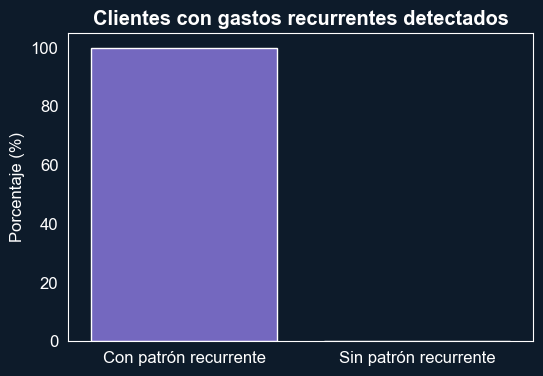

In [409]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el estilo oscuro con tonos azulados/morados
sns.set_style("dark")
plt.style.use("dark_background")
plt.rcParams['axes.facecolor'] = '#0D1B2A'  # Azul oscuro
plt.rcParams['figure.facecolor'] = '#0D1B2A'
plt.rcParams['axes.edgecolor'] = '#FFFFFF'
plt.rcParams['axes.labelcolor'] = '#FFFFFF'
plt.rcParams['xtick.color'] = '#FFFFFF'
plt.rcParams['ytick.color'] = '#FFFFFF'
plt.rcParams['text.color'] = '#FFFFFF'
plt.rcParams['axes.titlecolor'] = '#FFFFFF'

# Crear la gráfica
plt.figure(figsize=(6, 4))
sns.barplot(x=["Con patrón recurrente", "Sin patrón recurrente"],
            y=[porcentaje_recurrentes, 100 - porcentaje_recurrentes],
            palette=["#6A5ACD", "#708090"])  # SlateBlue y SlateGray
plt.title("Clientes con gastos recurrentes detectados")
plt.ylabel("Porcentaje (%)")
plt.show()


In [410]:
# Filtrar transacciones recurrentes
df_tx['fecha'] = pd.to_datetime(df_tx['fecha'])
df_tx_recurrente = df_tx.groupby(['id', 'comercio']).filter(lambda x: x['fecha'].nunique() > 1)
top_comercios = df_tx_recurrente['comercio'].value_counts().head(10)


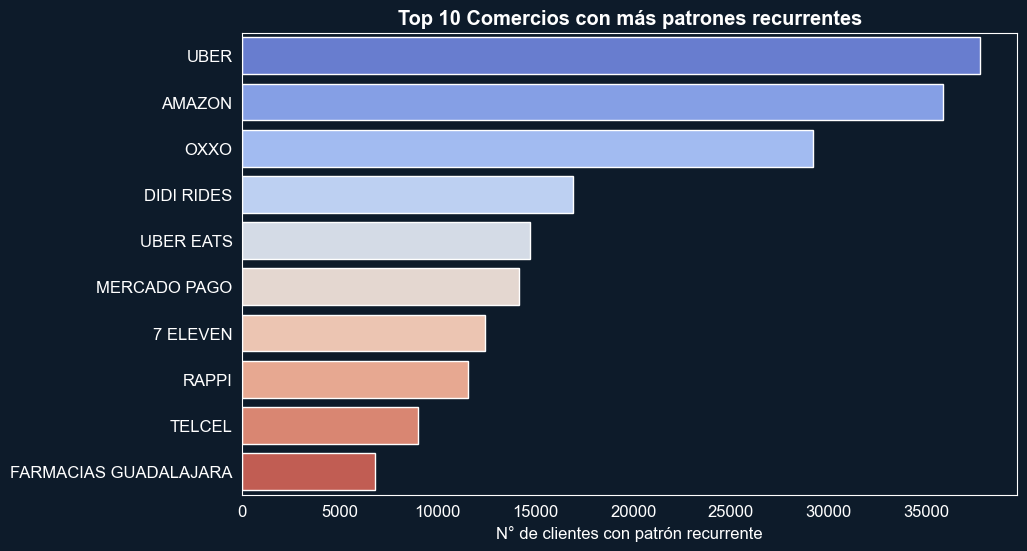

In [411]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_comercios.values,
            y=top_comercios.index,
            palette="coolwarm")
plt.title("Top 10 Comercios con más patrones recurrentes")
plt.xlabel("N° de clientes con patrón recurrente")
plt.show()


In [412]:
total_gasto = df_tx['monto'].sum()
total_recurrente = df_tx_recurrente['monto'].sum()
porcentaje_recurrente = 100 * total_recurrente / total_gasto


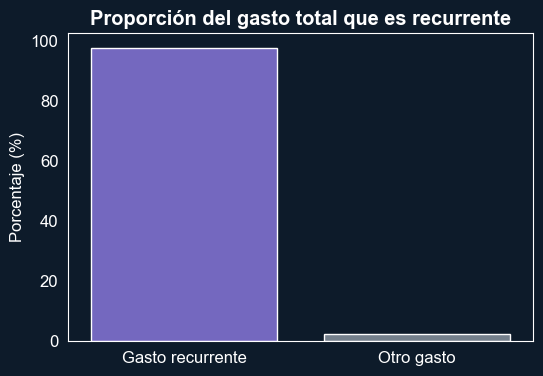

In [414]:
plt.figure(figsize=(6, 4))
sns.barplot(x=["Gasto recurrente", "Otro gasto"],
            y=[porcentaje_recurrente, 100 - porcentaje_recurrente],
            palette=["#6A5ACD", "#708090"])  # DarkOrange y SlateGray
plt.title("Proporción del gasto total que es recurrente")
plt.ylabel("Porcentaje (%)")
plt.show()


In [415]:
from datetime import datetime

df_clientes['fecha_nacimiento'] = pd.to_datetime(df_clientes['fecha_nacimiento'])
df_clientes['edad'] = df_clientes['fecha_nacimiento'].apply(lambda x: datetime.now().year - x.year)

# Crear rangos de edad
bins = [18, 25, 35, 45, 55, 65, 80]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df_clientes['rango_edad'] = pd.cut(df_clientes['edad'], bins=bins, labels=labels, right=False)


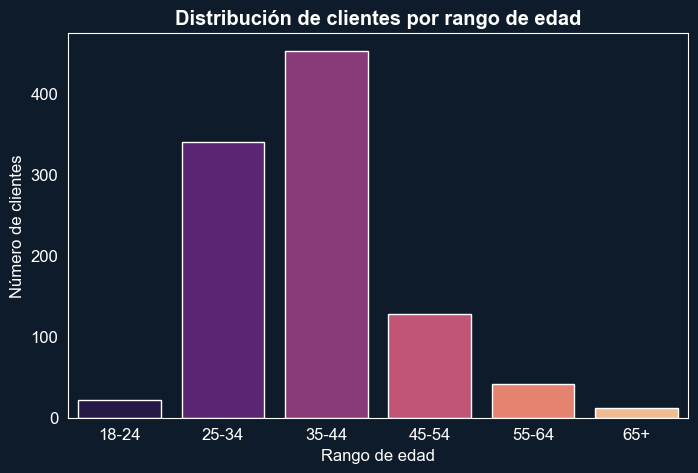

In [416]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clientes, x='rango_edad', palette='magma')
plt.title('Distribución de clientes por rango de edad')
plt.xlabel('Rango de edad')
plt.ylabel('Número de clientes')
plt.show()


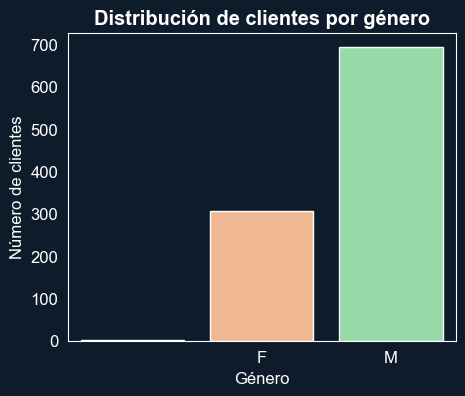

In [417]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df_clientes, x='genero', palette='pastel')
plt.title('Distribución de clientes por género')
plt.xlabel('Género')
plt.ylabel('Número de clientes')
plt.show()


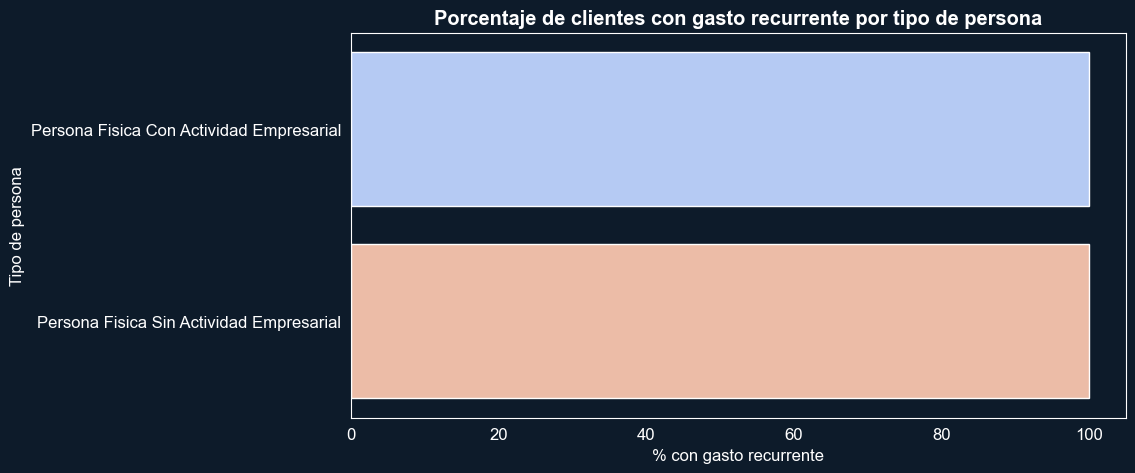

In [418]:
clientes_con_recurrente = df_tx_recurrente['id'].unique()
df_clientes['es_recurrente'] = df_clientes['id'].isin(clientes_con_recurrente)

# Agrupar por tipo_persona
tipo_persona_kpi = df_clientes.groupby('tipo_persona')['es_recurrente'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=tipo_persona_kpi.values, y=tipo_persona_kpi.index, palette='coolwarm')
plt.title('Porcentaje de clientes con gasto recurrente por tipo de persona')
plt.xlabel('% con gasto recurrente')
plt.ylabel('Tipo de persona')
plt.show()


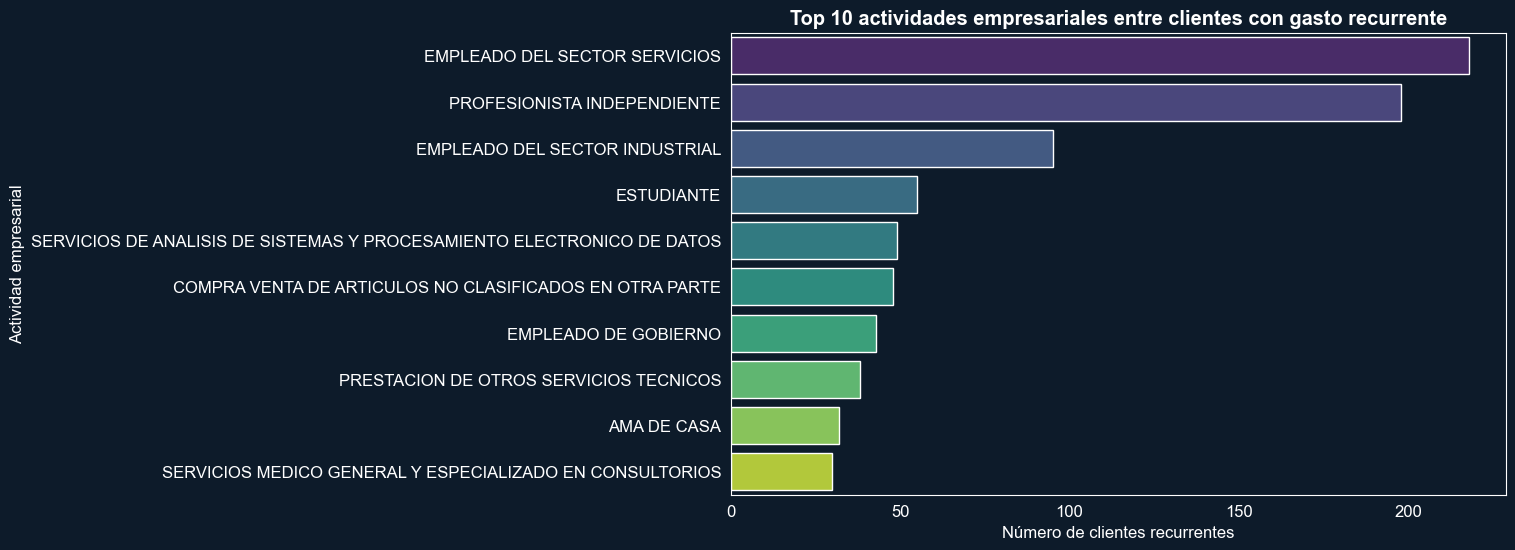

In [419]:
top_actividades = (
    df_clientes[df_clientes['es_recurrente']]
    ['actividad_empresarial']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_actividades.values, y=top_actividades.index, palette='viridis')
plt.title('Top 10 actividades empresariales entre clientes con gasto recurrente')
plt.xlabel('Número de clientes recurrentes')
plt.ylabel('Actividad empresarial')
plt.show()


In [420]:
kpi_1 = 100 * df_clientes['es_recurrente'].mean()


In [422]:
ticket_recurrente = df_tx_recurrente['monto'].mean()
ticket_otro = df_tx[~df_tx.index.isin(df_tx_recurrente.index)]['monto'].mean()


In [423]:
porcentaje_gasto_recurrente = 100 * df_tx_recurrente['monto'].sum() / df_tx['monto'].sum()


In [424]:
predictibilidad = df_tx_recurrente.groupby(['id', 'comercio']).agg({
    'fecha': lambda x: x.sort_values().diff().dt.days.std(),
    'monto': 'std'
}).dropna()

clientes_predecibles = predictibilidad[(predictibilidad['fecha'] < 10) & (predictibilidad['monto'] < 5)]
kpi_predecibles = clientes_predecibles.reset_index()['id'].nunique()


In [425]:
top_recurrentes = df_tx_recurrente['comercio'].value_counts().head(5)


In [426]:
df_tx_recurrente['mes'] = pd.to_datetime(df_tx_recurrente['fecha']).dt.to_period('M')
retencion_mensual = df_tx_recurrente.groupby('mes')['id'].nunique()


In [428]:
patrones_fijos = df_tx.groupby(['id', 'comercio', 'monto']).size().reset_index(name='repeticiones')
clientes_fijos = patrones_fijos[patrones_fijos['repeticiones'] >= 3]['id'].nunique()


In [430]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Estilos
sns.set_style("dark")
plt.style.use("dark_background")

# Convertir fechas
df_tx["fecha"] = pd.to_datetime(df_tx["fecha"])

# Detectar transacciones recurrentes: mismo cliente, mismo comercio, mismo monto, 3+ veces
df_recurrentes = df_tx.groupby(["id", "comercio", "monto"]).filter(lambda x: len(x) >= 3)

# % clientes con gastos recurrentes
clientes_con_rec = df_recurrentes["id"].nunique()
clientes_totales = df_clientes["id"].nunique()
porcentaje_recurrentes = 100 * clientes_con_rec / clientes_totales

# % del gasto total que es recurrente
gasto_total = df_tx["monto"].sum()
gasto_recurrente = df_recurrentes["monto"].sum()
porcentaje_gasto_recurrente = 100 * gasto_recurrente / gasto_total


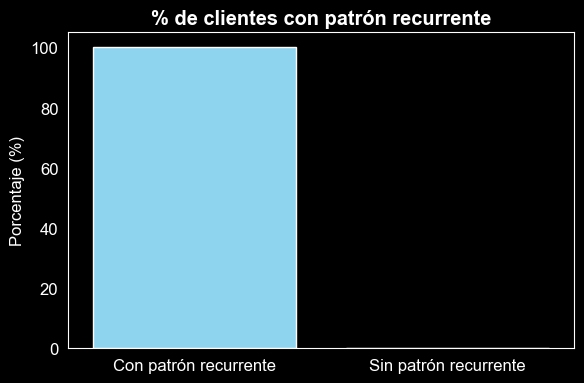

In [431]:
plt.figure(figsize=(6, 4))
sns.barplot(x=["Con patrón recurrente", "Sin patrón recurrente"],
            y=[porcentaje_recurrentes, 100 - porcentaje_recurrentes],
            palette=["#7FDBFF", "gray"])
plt.title("% de clientes con patrón recurrente")
plt.ylabel("Porcentaje (%)")
plt.tight_layout()
plt.show()


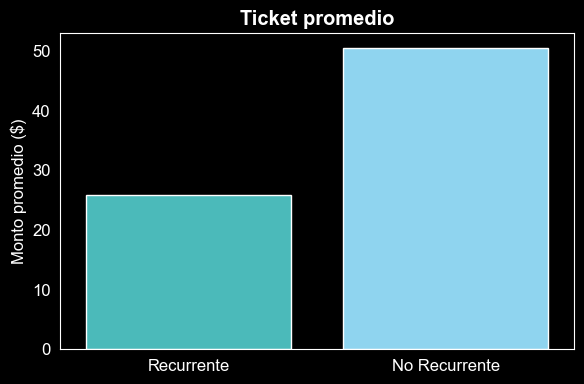

In [437]:
monto_rec = df_recurrentes["monto"].mean()
monto_no_rec = df_tx[~df_tx.index.isin(df_recurrentes.index)]["monto"].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=["Recurrente", "No Recurrente"],
            y=[monto_rec, monto_no_rec],
            palette=["#39CCCC", "#7FDBFF"])
plt.title("Ticket promedio")
plt.ylabel("Monto promedio ($)")
plt.tight_layout()
plt.show()


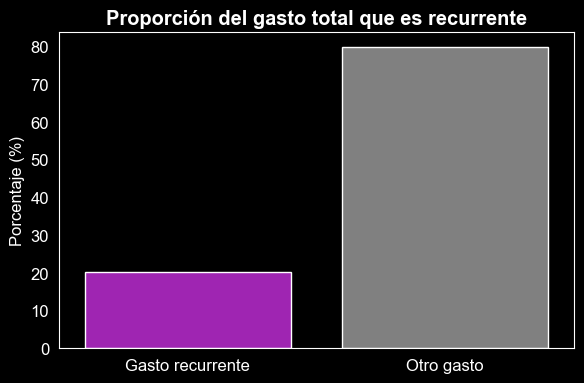

In [433]:
plt.figure(figsize=(6, 4))
sns.barplot(x=["Gasto recurrente", "Otro gasto"],
            y=[porcentaje_gasto_recurrente, 100 - porcentaje_gasto_recurrente],
            palette=["#B10DC9", "gray"])
plt.title("Proporción del gasto total que es recurrente")
plt.ylabel("Porcentaje (%)")
plt.tight_layout()
plt.show()


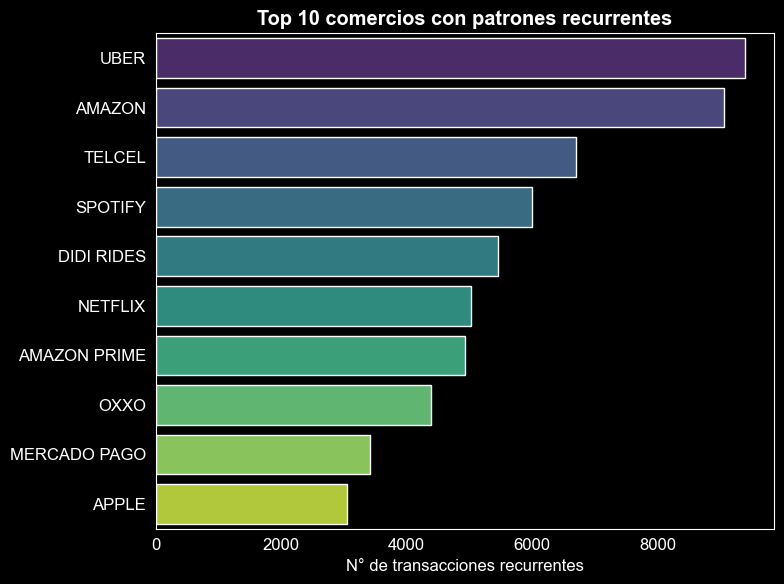

In [434]:
top_comercios = df_recurrentes["comercio"].value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_comercios.values,
            y=top_comercios.index,
            palette="viridis")
plt.title("Top 10 comercios con patrones recurrentes")
plt.xlabel("N° de transacciones recurrentes")
plt.tight_layout()
plt.show()


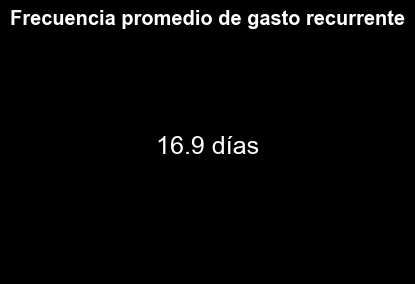

In [435]:
df_recurrentes = df_recurrentes.sort_values(by=["id", "comercio", "fecha"])
df_recurrentes["dias_diff"] = df_recurrentes.groupby(["id", "comercio"])["fecha"].diff().dt.days
frecuencia_prom = df_recurrentes["dias_diff"].dropna().mean()

plt.figure(figsize=(4, 3))
plt.text(0.5, 0.5, f"{frecuencia_prom:.1f} días", color="white", fontsize=18, ha='center')
plt.title("Frecuencia promedio de gasto recurrente")
plt.axis("off")
plt.tight_layout()
plt.show()


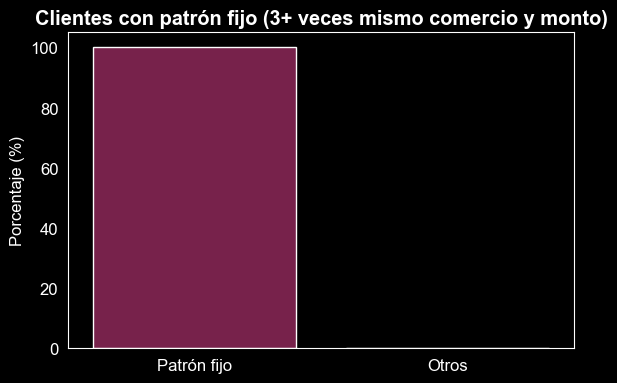

In [436]:
fijos = df_recurrentes.groupby(["id", "comercio", "monto"]).size()
clientes_fijos = fijos[fijos >= 3].reset_index()["id"].nunique()
porcentaje_fijos = 100 * clientes_fijos / clientes_totales

plt.figure(figsize=(6, 4))
sns.barplot(x=["Patrón fijo", "Otros"],
            y=[porcentaje_fijos, 100 - porcentaje_fijos],
            palette=["#85144b", "gray"])
plt.title("Clientes con patrón fijo (3+ veces mismo comercio y monto)")
plt.ylabel("Porcentaje (%)")
plt.tight_layout()
plt.show()
